## Computing library matching

Code taken and addapted from Florian Huber's Jupyter notebooks to perform an experiment of Library matching
https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/notebooks/iomega-8-library-matching.ipynb

In [128]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())

sys.path.insert(0, ROOT)

In [129]:
from custom_functions.spectra_functions import get_data_folder_path

path = get_data_folder_path(False)

In [130]:
from matchms.importing import load_from_msp

spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")
spectrums = [s for s in load_from_msp(spectrums_file)]

print("Number of spectra:", len(spectrums))

Number of spectra: 14847


Text(0, 0.5, 'number of spectra in respective bin')

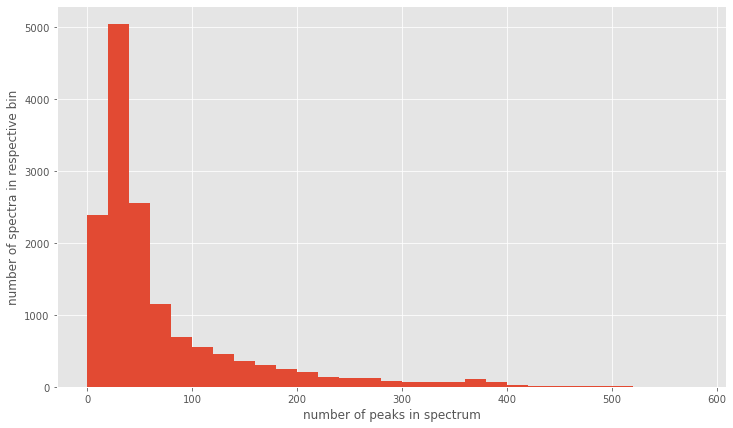

In [131]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12, 7))
hist = plt.hist(number_of_peaks, np.arange(0,600,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [132]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

spectrums_classical = [post_process_classical(s) for s in spectrums]

spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

14847 remaining spectra.


In [133]:
def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
    return s

spectrums_s2v = [post_process_s2v(s) for s in spectrums]

spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

14847 remaining spectra.


Text(0, 0.5, 'number of spectra in respective bin')

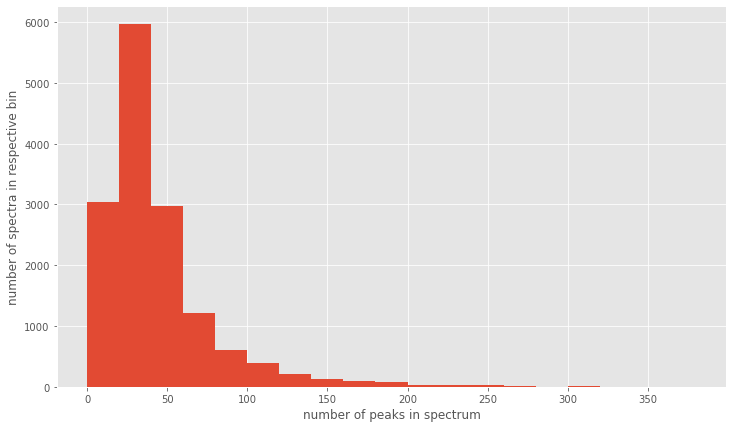

In [134]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_classical]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,400,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [135]:
np.max(number_of_peaks)

458

14847


Text(0, 0.5, 'number of spectra in respective bin')

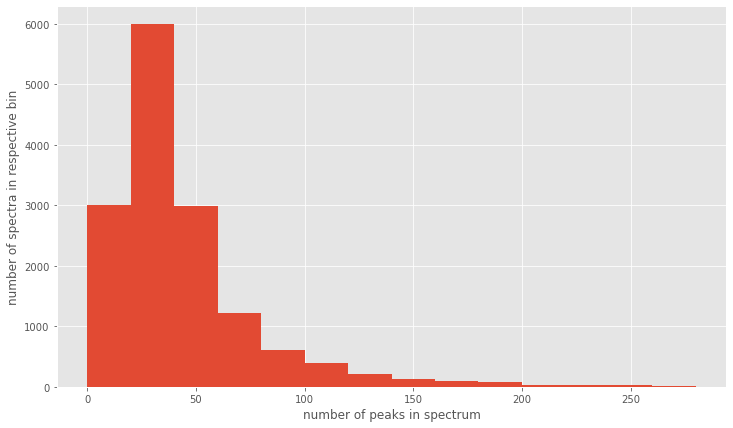

In [136]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]
print(len(number_of_peaks))
plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,300,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [137]:
np.max(number_of_peaks)

458

## Inspect annotations

In [138]:
Inchikeys = []
for spec in spectrums_classical:
    Inchikeys.append(spec.get("inchikey"))

In [139]:
Inchikeys[:10]

['ALRLPDGCPYIVHP-UHFFFAOYSA-N',
 'UFBJCMHMOXMLKC-UHFFFAOYSA-N',
 'WDNBURPWRNALGP-UHFFFAOYSA-N',
 'RANCECPPZPIPNO-UHFFFAOYSA-N',
 'HOLHYSJJBXSLMV-UHFFFAOYSA-N',
 'UMPSXRYVXUPCOS-UHFFFAOYSA-N',
 'HFZWRUODUSTPEG-UHFFFAOYSA-N',
 'VPOMSPZBQMDLTM-UHFFFAOYSA-N',
 'LHJGJYXLEPZJPM-UHFFFAOYSA-N',
 'LINPIYWFGCPVIE-UHFFFAOYSA-N']

In [140]:
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:30]

WQZGKKKJIJFFOK    29
GUBGYTABKSRVRQ    21
DCXYFEDJOCDNAF    18
GZCGUPFRVQAUEE    16
MBWXNTAXLNYFJB    16
BJHIKXHVCXFQLS    16
DLYVTEULDNMQAR    16
ZDXPYRJPNDTMRX    15
FBPFZTCFMRRESA    15
VZCYOOQTPOCHFL    15
AYFVYJQAPQTCCC    14
BTCSSZJGUNDROE    14
HEBKCHPVOIAQTA    14
GLZPCOQZEFWAFX    14
KZSNJWFQEVHDMF    14
KIDHWZJUCRJVML    14
PFNFFQXMRSDOHW    13
UFWIBTONFRDIAS    13
CKLJMWTZIZZHCS    13
KYZHGEFMXZOSJN    13
OUYCCCASQSFEME    13
WTEVQBCEXWBHNA    12
AHLPHDHHMVZTML    12
DHMQDGOQFOQNFH    12
OFOBLEOULBTSOW    11
QIVBCDIJIAJPQS    11
LRQKBLKVPFOOQJ    11
QNAYBMKLOCPYGJ    11
HNEGQIOMVPPMNR    11
IEPRKVQEAMIZSS    11
dtype: int64

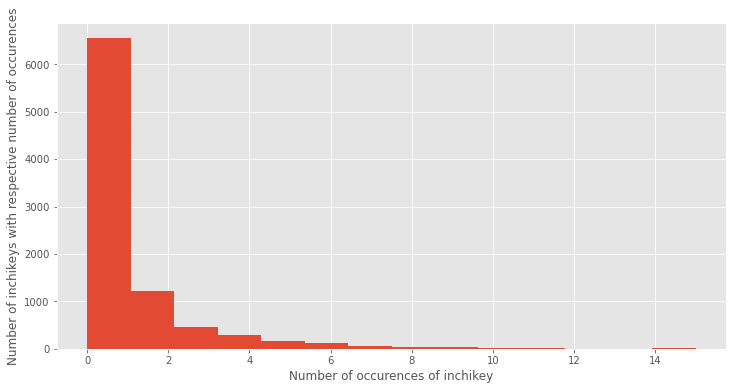

In [141]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 15, 15))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.show()

In [142]:
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,WQZGKKKJIJFFOK,29
1,GUBGYTABKSRVRQ,21
2,DCXYFEDJOCDNAF,18
4,MBWXNTAXLNYFJB,16
3,GZCGUPFRVQAUEE,16
6,DLYVTEULDNMQAR,16
5,BJHIKXHVCXFQLS,16
7,ZDXPYRJPNDTMRX,15
9,VZCYOOQTPOCHFL,15
8,FBPFZTCFMRRESA,15


In [143]:
print("Number of spectra with inchikeys that exist >= 5 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 5 times: 472


## Randomly select 300 inchikeys that exist >=5 times in the dataset

In [144]:
num_spectra = 300

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[ 55  73  33 278 244 380 211   9 126  70  78 180 351 175 459 450 148  93
 427  77   0 467  11 153  76]


array(['YNPNZTXNASCQKK', 'MFGTZDMAYACKNE', 'LDCRTTXIJACKKU',
       'DURPTKYDGMDSBL', 'MXHRCPNRJAMMIM', 'OAYXUHPQHDHDDZ',
       'UZTFMUBKZQVKLK', 'FBPFZTCFMRRESA', 'DRTQHJPVMGBUCF',
       'PCMORTLOPMLEFB', 'JRLGPAXAGHMNOL', 'FDGQSTZJBFJUBT',
       'SUHOOTKUPISOBE', 'ISWSIDIOOBJBQZ', 'BJQHLKABXJIVAM',
       'DNXHEGUUPJUMQT', 'QYIXCDOBOSTCEI', 'ZSIAUFGUXNUGDI',
       'GWCTUKHUBWMAMI', 'KJPRLNWUNMBNBZ', 'WQZGKKKJIJFFOK',
       'AOGQPLXWSUTHQB', 'KIDHWZJUCRJVML', 'PAJPWUMXBYXFCZ',
       'KKADPXVIOXHVKN'], dtype=object)

### Randomly pick one spectra for each of the chosen inchikeys

In [145]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [146]:
selected_spectra[:10]

[11655, 5641, 10339, 8472, 14697, 6925, 13677, 12510, 12625, 13906]

In [147]:
# Show inchikeys for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_s2v[ID].get("inchikey")[:14])

YNPNZTXNASCQKK
MFGTZDMAYACKNE
LDCRTTXIJACKKU
DURPTKYDGMDSBL
MXHRCPNRJAMMIM
OAYXUHPQHDHDDZ
UZTFMUBKZQVKLK
FBPFZTCFMRRESA
DRTQHJPVMGBUCF
PCMORTLOPMLEFB


## Train new model on AllPositive dataset WITHOUT selected spectra

In [148]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [149]:

documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i not in selected_spectra and len(s.peaks) > 0]


In [150]:

documents_library_classical = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_classical) if i not in selected_spectra and len(s.peaks) > 0]


In [151]:
len(documents_library_s2v), len(spectrums_s2v)

(14544, 14847)

In [152]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library_s2v, iterations, model_file)


  Epoch 1 of 20.Change in loss after epoch 1: 256029.453125
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_librarymatching_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 268040.671875
  Epoch 3 of 20.Change in loss after epoch 3: 237758.125
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_librarymatching_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 224105.0625
  Epoch 5 of 20.Change in loss after epoch 5: 224361.8125
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_librarymatching_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 220502.0
  Epoch 7 of 20.Change in loss after epoch 7: 203793.75
  Epoch 8 of 20.Change in loss after epoch 8: 228308.25
  Epoch 9 of 20.Change in loss after epoch 9: 216620.625
  Epoch 10 of 20.Change in loss after epoch 10: 208020.0
Saving model with name: /Users/efra/dev/spec2vec

### Actual library matching

In [153]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

#### Load word2vec model

In [154]:
from custom_functions.library_search import library_matching

path_models = os.path.join(path, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching.model")
model = gensim.models.Word2Vec.load(model_file)


In [155]:

documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]


In [156]:

documents_query_classical = [SpectrumDocument(spectrums_classical[i], n_decimals=2) for i in selected_spectra]


In [157]:
len(documents_query_s2v)

300

In [158]:
len(documents_query_s2v), len(documents_library_s2v)

(300, 14544)

In [159]:
documents_query_s2v[0]._obj.get("inchikey")

'YNPNZTXNASCQKK-UHFFFAOYSA-N'

In [160]:
found_matches_s2v = library_matching(documents_query_s2v, documents_library_s2v,
                                     model,
                                     presearch_based_on=["spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     include_scores=["spec2vec", "cosine"], # Here modcofine index uses cosine greedy
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=15.0,
                                     cosine_tol=0.005)


Pre-selection includes spec2vec top 20.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.36%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 4.94%.


In [161]:
found_matches_classical = library_matching(documents_query_classical, documents_library_classical,
                                           model,
                                           presearch_based_on=["spec2vec-top20"],
                                           include_scores=["cosine"],
                                           ignore_non_annotated=True,
                                           intensity_weighting_power=0.5,
                                           allowed_missing_percentage=50.0,
                                           cosine_tol=0.005)

Pre-selection includes spec2vec top 20.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.36%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 4.94%.


In [162]:
len(found_matches_s2v), len(found_matches_classical)

(300, 300)

In [163]:

found_matches_s2v[0].sort_values(by=["s2v_score"], ascending=False)

,cosine_score,cosine_matches,s2v_score
11493,0.994582,7,0.989886
11494,0.997771,7,0.968116
13878,0.954727,7,0.770387
5721,0.962086,3,0.762708
12775,0.961239,6,0.760155
4806,0.953068,3,0.747226
9801,0.955043,4,0.739603
12984,0.912656,7,0.737878
8812,0.943106,4,0.736097
8931,0.928268,4,0.718276


In [164]:
found_matches_classical[0].sort_values(by=["cosine_score"], ascending=False)

,cosine_score,cosine_matches,s2v_score
11494,0.997771,7,0.968116
11493,0.994582,7,0.989886
5721,0.962086,3,0.762708
12775,0.961239,6,0.760155
9801,0.955043,4,0.739603
13878,0.954727,7,0.770387
4806,0.953068,3,0.747226
8812,0.943106,4,0.736097
12958,0.935428,4,0.678103
8931,0.928268,4,0.718276


In [165]:
ID = 0
threshold = 0.5
min_match = 1
df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['cosine_score'] > threshold)
                     & (found_matches_s2v[ID]['cosine_matches'] >= min_match)]
best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
print(documents_library_s2v[best_match_ID]._obj.get("inchikey"))
print(documents_query_s2v[ID]._obj.get("inchikey"))


JRXXLCKWQFKACW-UHFFFAOYSA-N
YNPNZTXNASCQKK-UHFFFAOYSA-N


## Evaluate different similarity score thresholds

In [166]:
min_match = 2
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min2 = []
for threshold in cosine_thresholds:
    print("Checking matches for cosine score >", threshold)
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['cosine_score'] > threshold)
                                         & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)

    test_matches_min2.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.0
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.1
Checking matches for cosine score > 0.15000000000000002
Checking matches for cosine score > 0.2
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30000000000000004
Checking matches for cosine score > 0.35000000000000003
Checking matches for cosine score > 0.4
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.5
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.6000000000000001
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.7000000000000001
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.8
Checking matches for cosine score > 0.8500000000000001
Checking matches for cosine score > 0.9
Checking matches for cosine score > 0.9500000000000001


Text(0, 0.5, 'true positives')

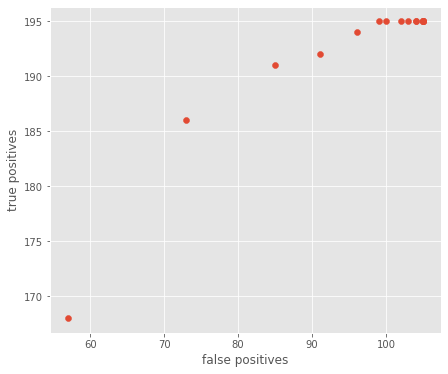

In [167]:
test_matches_arr = np.array(test_matches_min2)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [168]:
min_match = 6
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min6 = []
for threshold in cosine_thresholds:
    print("Checking matches for cosine score >", threshold)
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['cosine_score'] > threshold)
                                             & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_min6.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.0
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.1
Checking matches for cosine score > 0.15000000000000002
Checking matches for cosine score > 0.2
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30000000000000004
Checking matches for cosine score > 0.35000000000000003
Checking matches for cosine score > 0.4
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.5
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.6000000000000001
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.7000000000000001
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.8
Checking matches for cosine score > 0.8500000000000001
Checking matches for cosine score > 0.9
Checking matches for cosine score > 0.9500000000000001


Text(0, 0.5, 'true positives')

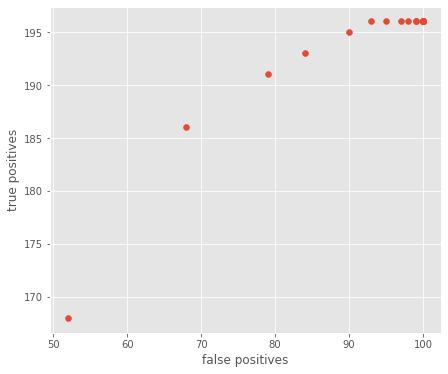

In [169]:
test_matches_arr = np.array(test_matches_min6)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [170]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print("Checking matches for S2V score >", threshold)
    test_matches = []
    
    for ID in range(len(documents_query_s2v)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for S2V score > 0.0
Checking matches for S2V score > 0.05
Checking matches for S2V score > 0.1
Checking matches for S2V score > 0.15000000000000002
Checking matches for S2V score > 0.2
Checking matches for S2V score > 0.25
Checking matches for S2V score > 0.30000000000000004
Checking matches for S2V score > 0.35000000000000003
Checking matches for S2V score > 0.4
Checking matches for S2V score > 0.45
Checking matches for S2V score > 0.5
Checking matches for S2V score > 0.55
Checking matches for S2V score > 0.6000000000000001
Checking matches for S2V score > 0.65
Checking matches for S2V score > 0.7000000000000001
Checking matches for S2V score > 0.75
Checking matches for S2V score > 0.8
Checking matches for S2V score > 0.8500000000000001
Checking matches for S2V score > 0.9
Checking matches for S2V score > 0.9500000000000001


Text(0, 0.5, 'true positives')

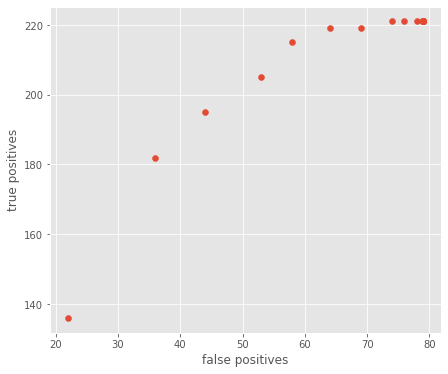

In [171]:
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

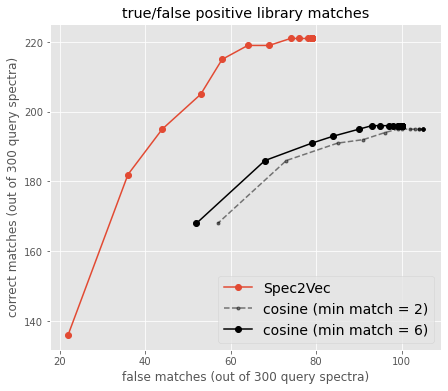

In [172]:
test_matches_min2_arr = np.array(test_matches_min2)
test_matches_min6_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0], 
         'o-', label='Spec2Vec')
plt.plot(test_matches_min2_arr[:,1], test_matches_min2_arr[:,0], 
         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')
plt.plot(test_matches_min6_arr[:,1], test_matches_min6_arr[:,0], 
         'o-', color='black', label='cosine (min match = 6)')
plt.title('true/false positive library matches')
plt.legend(fontsize=14)
plt.xlabel('false matches (out of 300 query spectra)')
plt.ylabel('correct matches (out of 300 query spectra)')
plt.savefig('library_matching_true_false_positives_absolute_200728.pdf')

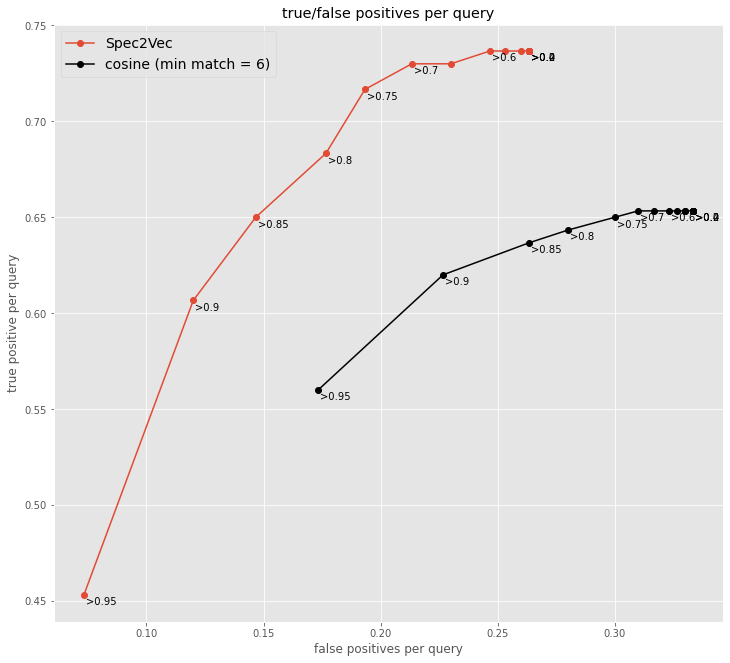

In [173]:
min_match = 6
#test_matches_cosine_arr = np.array(test_matches_ROC_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

plt.figure(figsize=(12,11))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10))
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10))

#plt.plot(test_matches_ROC_min2_arr[:,1]/num_max, test_matches_ROC_min2_arr[:,0]/num_max, 
#         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xlabel('false positives per query')
plt.ylabel('true positive per query')
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true_false_positives_labeled_200728.pdf')

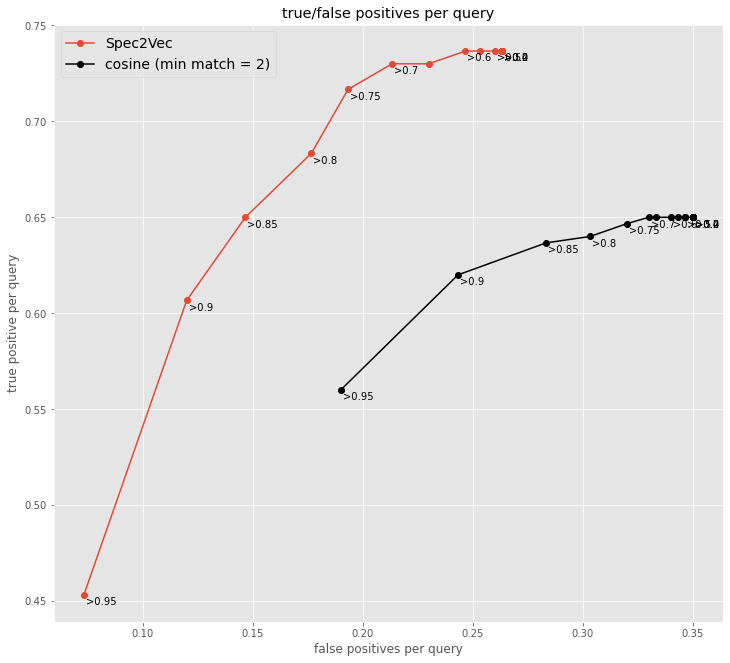

In [174]:
min_match = 2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

plt.figure(figsize=(12,11))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10))
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10))

#plt.plot(test_matches_ROC_min2_arr[:,1]/num_max, test_matches_ROC_min2_arr[:,0]/num_max, 
#         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xlabel('false positives per query')
plt.ylabel('true positive per query')
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true_false_positives_labeled_minmatch2_200728.pdf')

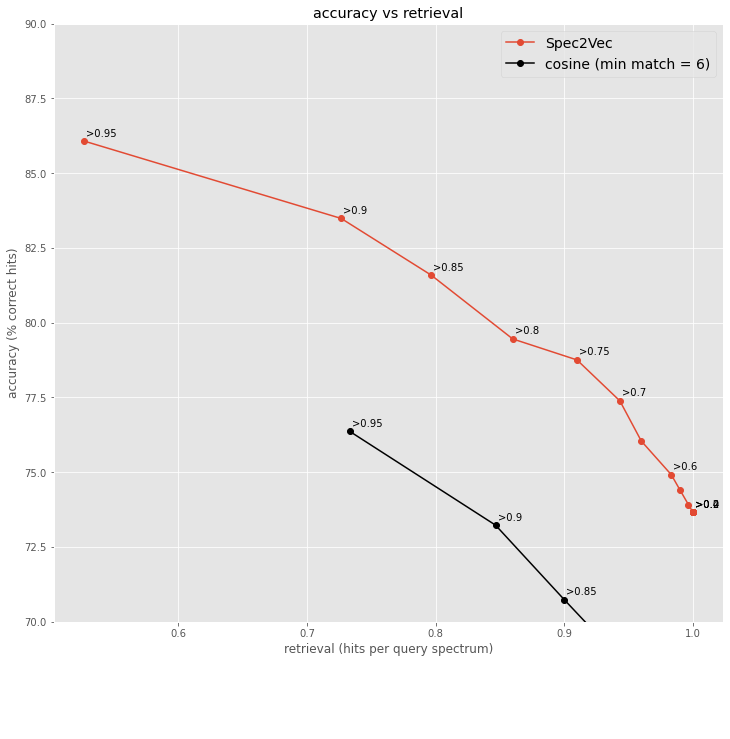

In [175]:
min_match=6
#test_matches_cosine_arr = np.array(test_matches_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/300
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/300

plt.figure(figsize=(12,11))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5))
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5))

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.ylim([70, 90])
plt.xlabel('retrieval (hits per query spectrum)')
plt.ylabel('accuracy (% correct hits)')
plt.savefig('library_matching_accuracy_vs_retrieval_200728.pdf')

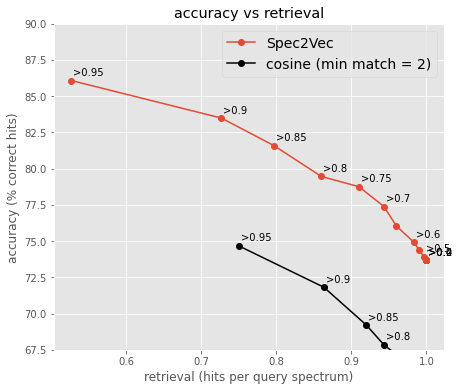

In [176]:
min_match=2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/300
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/300

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5))
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5))

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.ylim([67.5, 90])
plt.xlabel('retrieval (hits per query spectrum)')
plt.ylabel('accuracy (% correct hits)')
plt.savefig('library_matching_accuracy_vs_retrieval_minmatch2_200728.pdf')